# **Computer Vision Project**

Achilli Mattia, Rettaroli Andrea

# **Introduction to the problem**



This problem focuses on semantic understanding of urban scenes for increasing the safety of autonomous drone flight and landing procedures. The imagery depicts more than 20 houses from nadir (bird's eye) view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000x4000px (24Mpx). The training set contains 400 publicly available images and the test set is made up of 200 private images.

The complexity of the dataset is limited to 20 classes: tree, gras, other vegetation, dirt, gravel, rocks, water, paved area, pool, person, dog, car, bicycle, roof, wall, fence, fence-pole, window, door, obstacle

Kaggle's link [here](https://www.kaggle.com/bulentsiyah/semantic-drone-dataset).

# **Preliminary operations**

In this section we prepare the necessary material for this project.

First of all we install the package dedicated to kaggle to download the dataset.

In [ ]:
! pip install -q kaggle

Then we need to load our Kaggle's API

In [ ]:
from google.colab import files

files.upload()

The below code removes any file and delete .kaggle directory, move the uploaded token to a newly created directory.

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download Dataset from Kaggle using Kaggle's API and unzip.

In [ ]:
! kaggle datasets download -d bulentsiyah/semantic-drone-dataset

!unzip ./data/semantic-drone-dataset.zip

!rm ./data/semantic-drone-dataset.zip

# **Import base libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
import glob
import os
import sklearn
import seaborn as sns
import GPUtil

from tensorflow import keras
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.preprocessing.image import ImageDataGenerator

# **Utility functions**

Functions for load images and respective masks.

In [2]:
HEIGHT = 320
WIDTH = 480

def get_file_name(file_path):
    return os.path.basename(file_path)

def get_file_paths(folder_path, search_pattern, search_in_subfolders=False):
    if (search_in_subfolders):
        pathname = folder_path+'/**/'+search_pattern
    else:
        pathname = folder_path+'/'+search_pattern

    file_paths = glob.glob(pathname,recursive=search_in_subfolders)

    return [path.replace('\\','/') for path in file_paths]

def normalize_image(image):
    image = image / 255.0
    image = image.astype(np.float32)
    
    return image

def normalize_mask(mask):
    mask = mask.astype(np.int32)
    
    return mask

def load_image_dataset_with_masks(image_folder_path, mask_folder_path, 
                                  image_search_pattern, image_count = None):
    image_file_path_list = get_file_paths(image_folder_path, image_search_pattern)

    images = []
    masks = []

    for image_file_path in image_file_path_list:
        if (image_count!= None and len(images) == image_count):
          break
        
        # Image read
        image = cv2.imread(image_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Image resize
        image = cv2.resize(image, (WIDTH, HEIGHT)) 
        
        # Image normalization
        image = normalize_image(image) 
        
        # Mask read
        mask = cv2.imread(mask_folder_path + '/' + get_file_name(image_file_path).replace("jpg", "png"), cv2.IMREAD_GRAYSCALE)
        
        # Mask resize
        mask = cv2.resize(mask, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)
        
        # Mask normalization
        mask = normalize_mask(mask)
        
        images.append(image)
        masks.append(mask)

    return np.array(images),np.array(masks)

# **Training Dataset** 

In this project the dataset contains 400 images and 400 respective masks (ground truth).

The number of classes is 23 (some classes included different elements).

Below code contains the code to show a random image and respective mask.

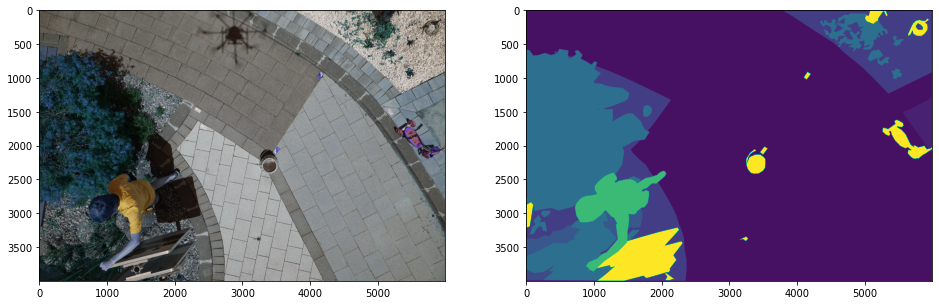

In [3]:
dataset_path = 'data/dataset/semantic_drone_dataset'
images_path = dataset_path + '/original_images'
masks_path = dataset_path + '/label_images_semantic'

random_image = random.choice(os.listdir(images_path))
random_mask = random_image.replace("jpg", "png")

# Show a random image
_, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(cv2.imread(images_path + "/" + random_image, cv2.COLOR_BGR2RGB));
axs[1].imshow(cv2.imread(masks_path + "/" + random_mask, cv2.IMREAD_GRAYSCALE));

Let's see the classes of the problem from the csv.

In [4]:
classes = pd.read_csv("data/class_dict_seg.csv")
classes

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


Get the number of classes from csv.

We remove conflicting class from the count because there are no pixels of this class.

In [5]:
number_of_classes = classes.loc[classes['name'] != "conflicting"].shape[0]

The original images have a size of 6000 x 4000, this leads a huge amount of ram memory when loaded. For this reason when the images are loaded we resize them to WIDTH x HEIGHT to reduce size and mantain aspect ratio.

In [6]:
# Loading images and mask
print('Loading images and masks...')
images, masks = load_image_dataset_with_masks(images_path, masks_path, '*')

print('Images shape: ', images.shape)
print('Masks shape: ', masks.shape)

Loading images and masks...
Images shape:  (400, 320, 480, 3)
Masks shape:  (400, 320, 480)


# **Preprocessing** 

In the cell below we transorm the masks into a flat array. It is useful for some operations.

In [7]:
masks_flatten = masks.flatten()

Below code shows a random image and respective mask resized.

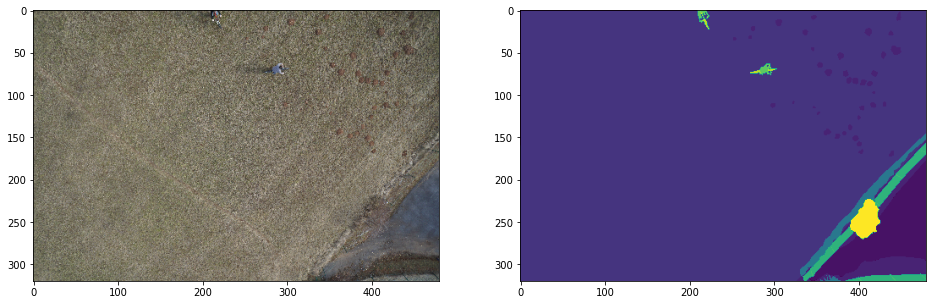

In [8]:
idx = random.randint(0, len(images))

_, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(images[idx]);
axs[1].imshow(masks[idx]);

In the cell below we sum the number of pixel in each mask for each class.

In [ ]:
for i in range (0, number_of_classes):
    print(f"Class {i}: ", sum(masks.flatten() == i))

We observed that this problem is not balanced so we compute the weight for each class.

In [9]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(masks), y = masks_flatten)
class_weights = dict(enumerate(class_weights))

Transform masks to categorical based on number of classes.

In [10]:
masks = to_categorical(masks, number_of_classes)

Now the dataset is loaded so we can split it into training and validation set.

90% of data is used for training and 10% for validation.

We use a random seed for reproducibility.

In [11]:
random_seed=42 
validation_size=0.10

train_x, validation_x, train_y, validation_y = train_test_split(images, masks,
                                                                test_size=validation_size,
                                                                random_state=random_seed)

print('Training set shape:', train_x.shape)
print('Validation set shape:', validation_x.shape)

print('Training labels shape:', train_y.shape)
print('Validation labels shape:', validation_y.shape)

Training set shape: (360, 320, 480, 3)
Validation set shape: (40, 320, 480, 3)
Training labels shape: (360, 320, 480, 23)
Validation labels shape: (40, 320, 480, 23)


# **Jaccard index**

Beyond accuracy for this type of problem we use **Jaccard Index** (or intersection over union) to measure the performances.

\begin{align*}
J(A,B)=\frac{|A\cap B|}{|A \cup B|}
\end{align*}

In [12]:
smooth = 1e-12

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

# **Models**

## **U-Net**


The U-Net model is a **fully convolutional neural network** originally proposed to perform binary segmentation (foreground and background) of medical images. It is essentially made up of three parts:
1. **Downsampling Path** - composed of 4 blocks, has the purpose of reducing the spatial dimensions of the input while increasing its depth. Each block consists of two convolution layers (3x3 filter, stride = 1, no padding and ReLU as activation function) and one max-pooling level (2x2, stride = 2 and no padding).
2. **Bottleneck** - composed of two convolutional layers (3x3 filter, stride = 1, no padding and ReLU as activation function).
3. **Upsampling Path** - composed of 4 blocks, it aims to bring the segmentation map returned by the Bottleneck to the spatial dimensions of the input image. Each block consists of a upsampling level to double the spatial dimensions, a convolution level (2x2 filter, stride = 1, no padding) that halves the number of channels, concatenation (skip connections) with the corresponding feature map of the Downsampling Path and finally two layers of convolution (filter 3x3, stride = 1, no padding and ReLU as activation function).

The final level of convolution (filter 1x1, stride = 1, no padding and Sigmoid as the activation function) is used to return a segmentation map with a depth equal to the number of problem classes. 


![alt text](https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/raw/53b5e697d3c010546b9443534a067541c4c50eb9/images/u-net-architecture.png)

### **Downsampling block**
The following cell defines the **down_block (...)** function to create a block of *downsampling* input data:
- the feature map (*x*);
- the number of filters (*filter_count*).

In [13]:
def down_block(x, filter_count):
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(x)
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(c)
    p = keras.layers.MaxPool2D(2, 2)(c)
    return c, p

### **Bottleneck**
The following cell defines the **bottleneck (...)** function to create the *bottleneck* input data:
- the feature map (*x*);
- the number of filters (*filter_count*).



In [14]:
def bottleneck(x, filter_count):
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(x) 
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(c)
    return c

### **Upsampling block**
The following cell defines the **up_block (...)** function to create an *upsampling* data input block:
- the feature map (*x*);
- the *skip connection* to concatenate (*skip*);
- the number of filters (*filter_count*).

In [15]:
def up_block(x, skip, filter_count):
    us = keras.layers.UpSampling2D(2)(x)
    c = keras.layers.Conv2D(filter_count, 2, padding='same')(us)
    concat = keras.layers.Concatenate()([c, skip])
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(concat)
    c = keras.layers.Conv2D(filter_count, 3, padding='same', activation='relu')(c)
    return c

### **Model definition**

The below code defines **U-Net** network with following parameters:

*   **image_shape**: input of images.
*   **block_filter_count**: number of filters to use in each downsampling and umpsampling block.
*   **n_classes**: number of classes of the problem.

In [16]:
def UNet(image_shape, block_filter_count, n_classes = number_of_classes):
        
    inputs = keras.layers.Input(image_shape)
        
    # Downsampling path
    p0 = inputs
    c1, p1 = down_block(p0, block_filter_count[0]) 
    c2, p2 = down_block(p1, block_filter_count[1]) 
    c3, p3 = down_block(p2, block_filter_count[2]) 
    c4, p4 = down_block(p3, block_filter_count[3]) 
    
    # Bottleneck
    bn = bottleneck(p4, block_filter_count[4])
    
    # Upsampling path
    u1 = up_block(bn, c4, block_filter_count[3]) 
    u2 = up_block(u1, c3, block_filter_count[2]) 
    u3 = up_block(u2, c2, block_filter_count[1]) 
    u4 = up_block(u3, c1, block_filter_count[0]) 
    
    # Output
    outputs = keras.layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(u4)
    
    # Reshape
    # outputs_reshaped = keras.layers.Reshape((image_shape[0] * image_shape[1], number_of_classes))(outputs) 

     
    return keras.models.Model(inputs, outputs)

### **Creating and compile the model**

In the cell below we define the number of filter, the optimizer and loss function.


In [26]:
block_filter_count = [32, 64, 128, 256, 512]

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

loss_function = "categorical_crossentropy"

First of all create the UNet using the function above.

In [27]:
model = UNet((train_x[0].shape), block_filter_count)

Then we compile the model adding the custom function jaccard index as metric.

In [28]:
# , sample_weight_mode="temporal"

model.compile(optimizer=optimizer, loss=loss_function, metrics=['acc', jaccard_index])

### **Model plot**

The code below shows summary of the model defined.

In [ ]:
model.summary()

Or we can see it graphically.

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True)

### **Training**

Now we are ready to train our network, we have to define the number of epochs and the batch size.

In [25]:
epoch_count = 1000

batch_size = 16

Now we have to define a matrix of size N_TRAINING_SET_SAMPLES * TOTAL_PIXEL, where each row is an image, in each entry we put the weight corresponding to the class of the pixel of that image.

In [ ]:
weights = np.zeros((train_x.shape[0], train_x.shape[1] * train_x.shape[2])) # N_SAMPLES * TOTAL_PIXEL

for j in range(weights.shape[0]): # For each image in training set
    labels_flatten = np.argmax(train_y, axis = -1)[j].flatten() # Get the pixels of ground truth of image
    for i in range(train_x.shape[1] * train_x.shape[2]): # For each pixel of image
        weights[j, i] = class_weights[labels_flatten[i]] # Put the weight for image (i) and pixel (j)

Finally we have to reshape train_y and validation_y in order to merge second and third dimension.

In [ ]:
train_y_reshape = np.reshape(train_y, (train_y.shape[0], train_y.shape[1] * train_y.shape[2] , number_of_classes))

In [ ]:
validation_y_reshape = np.reshape(validation_y, (validation_y.shape[0], validation_y.shape[1] * validation_y.shape[2], number_of_classes))

We define a ModelCheckpoint so that when we train the model we can save the best by jaccard index on validation set.

In addition we use an EarlyStopping to stop the training of the model if there isn't an improvement every "patience" epochs.

In [29]:
checkpoint = ModelCheckpoint('models/Unet_model.hdf5', monitor='val_jaccard_index', mode="max", verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_jaccard_index', mode="max", min_delta= 0.001, patience=50)

In [ ]:
history = model.fit(train_x, train_y_reshape, 
                    validation_data = (validation_x, validation_y_reshape), 
                    batch_size = batch_size, 
                    epochs = epoch_count, 
                    verbose = 1, 
                    callbacks=[checkpoint, early_stopping],
                    sample_weight=weights)

### Data augmentation

Below cell defines ImageDataGenerator for increase the quantity of data.

In [30]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             rotation_range=90,
                             brightness_range=[0.5, 1.5])


In [31]:
training_generator = datagen.flow(train_x, train_y, batch_size=batch_size)
validation_generator = datagen.flow(validation_x, validation_y, batch_size=batch_size)

In [ ]:
history = model.fit(training_generator,
                    validation_data=validation_generator,
                    epochs = epoch_count, 
                    verbose = 1, 
                    callbacks=[checkpoint, early_stopping])

Epoch 1/1000
23/23 [==============================] - ETA: 0s - loss: 4.0128 - acc: 0.2409 - jaccard_index: 0.0650
Epoch 00001: val_jaccard_index improved from -inf to 0.08785, saving model to models/Unet_model.hdf5
23/23 [==============================] - 32s 1s/step - loss: 4.0128 - acc: 0.2409 - jaccard_index: 0.0650 - val_loss: 2.5356 - val_acc: 0.3180 - val_jaccard_index: 0.0879
Epoch 2/1000
23/23 [==============================] - ETA: 0s - loss: 2.5058 - acc: 0.3529 - jaccard_index: 0.0874
Epoch 00002: val_jaccard_index did not improve from 0.08785
23/23 [==============================] - 21s 918ms/step - loss: 2.5058 - acc: 0.3529 - jaccard_index: 0.0874 - val_loss: 2.4592 - val_acc: 0.2972 - val_jaccard_index: 0.0723
Epoch 3/1000
23/23 [==============================] - ETA: 0s - loss: 2.4401 - acc: 0.3701 - jaccard_index: 0.0908
Epoch 00003: val_jaccard_index did not improve from 0.08785
23/23 [==============================] - 21s 898ms/step - loss: 2.4401 - acc: 0.3701 - ja

### **History analysis**

In this section we can analyze the trend of accuracy, loss and jaccard index both in training and in validation.

In [ ]:
# Accuracy
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

# Loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Jaccard index
training_jaccard = history.history["jaccard_index"]
validation_jaccard = history.history["val_jaccard_index"]

epochs_range = range(len(training_accuracy)) # Number of epochs

The code below plots accuracy, loss and jaccard index.

In [ ]:
# Plot accuracy
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot jaccard index
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, training_jaccard, label='Training Jaccard')
plt.plot(epochs_range, validation_jaccard, label='Validation Jaccard')
plt.title('Training and Validation Jaccard')
plt.legend()
plt.show()

# **Load best model**

Here we can load the best model, if we use a custom metric (like jaccard index) we have to pass these metrics in **load_model(...)**.

In [ ]:
dependencies = {'jaccard_index': jaccard_index}
model = keras.models.load_model('models/Unet_model.hdf5',custom_objects=dependencies)

# **Evalute model on validation set**

Now we can use the model to predict validation set images.

In [ ]:
validation_y_preds = model.predict(validation_x)
print('Prediction map shape: ', validation_y_preds.shape)
print('Prediction map type: ', validation_y_preds.dtype)

In [ ]:
train_y_preds = model.predict(train_x)
print('Prediction map shape: ', train_y_preds.shape)
print('Prediction map type: ', train_y_preds.dtype)

Below cell evaluates model on validation set computing loss, accuracy and jaccard index.

In [ ]:
model.evaluate(validation_x, validation_y_reshape)

Below cell evaluates model on training set computing loss, accuracy and jaccard index.

In [ ]:
model.evaluate(train_x, train_y_reshape)

Now we can compute the confusion matrix through confusion_matrix of sklearn.

To do this we have to convert validation_y and the predictions to a flatten array.

In [ ]:
flat_validation_y = np.argmax(validation_y, axis=-1).flatten()
flat_validation_y_preds = np.argmax(validation_y_preds, axis=-1).flatten()

Same for training

In [ ]:
flat_train_y = np.argmax(train_y, axis=-1).flatten()
flat_train_y_preds = np.argmax(train_y_preds, axis=-1).flatten()

The cell below computes and plots the confusion matrix using seaborn library and heatmap. 

On columns there are real values, on rows predicted.

In [ ]:
cm = confusion_matrix(flat_validation_y, flat_validation_y_preds) 

fig, ax = plt.subplots(figsize=(22, 22))
sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax);

In [ ]:
cm = confusion_matrix(flat_train_y, flat_train_y_preds) 

fig, ax = plt.subplots(figsize=(22, 22))
sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap='Blues', ax=ax);

And now we can compute Precision, Recall and F1-Score for each class for validation.

In [ ]:
cr = classification_report(flat_validation_y, flat_validation_y_preds, output_dict=True)

pd.DataFrame(cr).T

Same for training.

In [ ]:
cr = classification_report(flat_train_y, flat_train_y_preds, output_dict=True)

pd.DataFrame(cr).T

# **Create output map**

First of all we reshape from N_SAMPLES x TOTAL_PIXEL x NUMBER_OF_CLASSES to N_SAMPLES x HEIGHT x WIDTH x NUMBER_OF_CLASSES

In [ ]:
validation_y_preds_reshape = np.reshape(validation_y_preds, (validation_y.shape[0], validation_y.shape[1], validation_y.shape[2], number_of_classes))

For each pixel we convert to one-hot encoded to a single value (class of pixel).

In [ ]:
validation_y_preds_reshape = np.argmax(validation_y_preds_reshape, axis=-1)

In [ ]:
validation_y_original = np.argmax(validation_y, axis=-1)

In [ ]:
validation_metric = 'Jaccard'      # Accuracy or Jaccard
validation_image_to_show = 15 # Number of results to show

validation_scores=[]

for i in range(validation_y_preds_reshape.shape[0]):
    if (validation_metric == 'Accuracy'):
      score = sklearn.metrics.accuracy_score(validation_y_original[i].ravel(), validation_y_preds_reshape[i].ravel())
    elif (validation_metric == 'Jaccard'):
        score = sklearn.metrics.jaccard_score(validation_y_original[i].ravel(), validation_y_preds_reshape[i].ravel(), average="micro")
    validation_scores.append((i,score))

# **Show best results**

Executing the cell below we can see the best prediction maps obtained from the model.

In [ ]:
validation_scores.sort(key=lambda elem: elem[1], reverse=True)
    
_, axs = plt.subplots(validation_image_to_show, 3,figsize=(20, 3 * validation_image_to_show))

for i in range(validation_image_to_show):
  image_idx = validation_scores[i][0]
  axs[i, 0].imshow(validation_x[image_idx]) 
  axs[i, 0].axis('off')
  axs[i, 0].set_title('%d: %.3f'%(image_idx,validation_scores[i][1]))
    
  axs[i, 1].imshow(validation_y_original[image_idx])
  axs[i, 1].axis('off')
  axs[i, 1].set_title('Ground Truth')

  axs[i, 2].imshow(validation_y_preds_reshape[image_idx])
  axs[i, 2].axis('off')
  axs[i, 2].set_title('Prediction')

# **Show worst results**

In the opposite way exectuing the cell below we can see the worst prediction maps obtained from the model so that we can observe where the model miss.

In [ ]:
validation_scores.sort(key=lambda elem: elem[1])    
    
_, axs = plt.subplots(validation_image_to_show, 3,figsize=(20, 3 * validation_image_to_show))

for i in range(validation_image_to_show):
  image_idx = validation_scores[i][0]
  axs[i, 0].imshow(validation_x[image_idx]) 
  axs[i, 0].axis('off')
  axs[i, 0].set_title('%d: %.3f'%(image_idx,validation_scores[i][1]))
    
  axs[i, 1].imshow(validation_y_original[image_idx])
  axs[i, 1].axis('off')
  axs[i, 1].set_title('Ground Truth')

  axs[i, 2].imshow(validation_y_preds_reshape[image_idx])
  axs[i, 2].axis('off')
  axs[i, 2].set_title('Prediction')